# Lab 4 - Minería de texto

In [2]:
#Librerías
import pandas as pd
import preprocessor as p
import re
import nltk
import string 
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer,TFBertModel
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Input, Dense
import gensim
from gensim.models import Word2Vec

2022-09-02 05:37:14.339681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-02 05:37:14.339860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv('train.csv',encoding = "ISO-8859-1")

## Análisis exploratorio

In [ ]:
train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [ ]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

0    4342
1    3271
Name: target, dtype: int64
/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

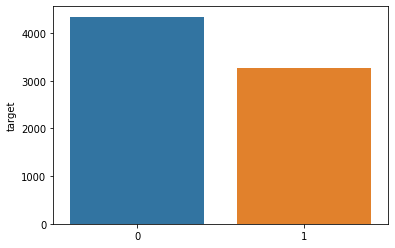

In [ ]:
x=train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [ ]:
train = train.dropna()
train = train.drop_duplicates()

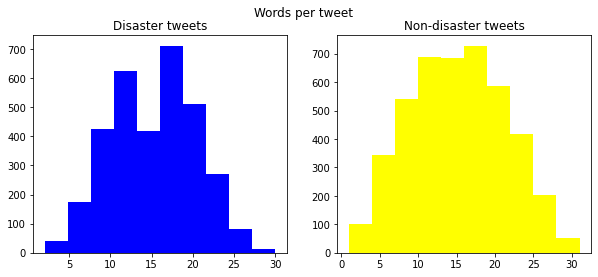

In [ ]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['target']==1]['word_count']
ax1.hist(train_words,color='blue')
ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['word_count']
ax2.hist(train_words,color='yellow')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [ ]:
train.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
train.text[train.text.str.contains('911')].count()

10

In [ ]:
punct = set(string.punctuation) 

def preprocess_tweet(row):
    text = row['text']
    #Removing unicodes
    text = text.encode(encoding="ascii", errors="ignore")
    text = text.decode()
    text = " ".join([word for word in text.split()])
    #Removing URLs, Hashtags, Punctuation, Mentions, etc.
    text = re.sub("@\S+", "", text)
    text = re.sub("\$", "", text)
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    text = re.sub("#", "", text)
    text = "".join([ch for ch in text if ch not in punct])
    if '911' not in text:
        text = ''.join([i for i in text if not i.isdigit()])
    return text
    
train['text'] = train.apply(preprocess_tweet, axis=1)

In [ ]:
train.text[train.text.str.contains('911')].count()

10

In [ ]:
train.head()


,id,keyword,location,text,target
31,48,ablaze,Birmingham,Wholesale Markets ablaze,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy metal RT,0
33,50,ablaze,AFRICA,AFRICANBAZE Breaking newsNigeria flag set abla...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
#Remover espacios, puntuación convertir a minuscula de la columna text
train['text'] = train['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/tmp/ipykernel_1633/3173529442.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['text'] = train['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_stop_words(row):
    text = row['text']
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    filtered_sentence = ' '.join((str(n) for n in filtered_sentence))
    return filtered_sentence
    
train['text'] = train.apply(preprocess_stop_words, axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Pasar los verbos a singular y generalizarlos (ej: wrecked -> wreck)

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_stemming_lemmatization(row):
    text = row['text']
    temp = text.split()
    for w in range(len(temp)):
        temp[w] = lemmatizer.lemmatize(temp[w])
        temp[w] = stemmer.stem(temp[w])
        
    text = ' '.join((str(n) for n in temp))
    return text

train['text'] = train.apply(preprocess_stemming_lemmatization, axis=1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
train['text']

31                                  wholesal market ablaz
32                         alway tri bring heavi metal rt
33        africanbaz break newsnigeria flag set ablaz aba
34                                          cri set ablaz
35                     plu side look sky last night ablaz
                              ...                        
7575                                    bright side wreck
7577    he gone relax thought wife wreck cake goner mi...
7579    three day work theyv pretti much wreck hahaha ...
7580    fx forex trade cramer iger word wreck disney s...
7581    great atmospher british lion gig tonight hear ...
Name: text, Length: 5080, dtype: object

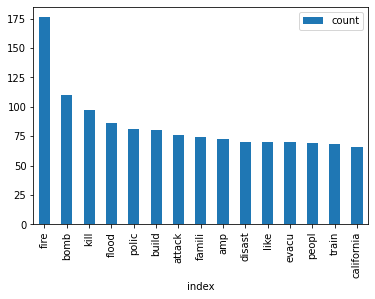

In [ ]:
#Frecuencia de palabras cuando es un desastre natural
desTrain = pd.DataFrame(train[train['target'] == 1].text.str.split(expand=True).stack().value_counts().nlargest(15), columns=['count'])
ax = desTrain.reset_index().plot.bar(x='index', y='count')

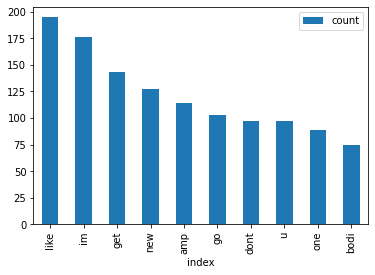

In [ ]:
#Frecuencia de palabras cuando es metaforico
metaTrain = pd.DataFrame(train[train['target'] == 0].text.str.split(expand=True).stack().value_counts().nlargest(10), columns=['count'])
ax = metaTrain.reset_index().plot.bar(x='index', y='count')

In [ ]:
#Palabras que aparecen en ambas categorias
metaTrain[~metaTrain.isin(desTrain)].dropna()

,count
like,195
im,176
get,143
new,127
amp,114
go,103
dont,97
u,97
one,89
bodi,75


In [ ]:
#ngramas de tweets metaforicos
stoplist = stopwords.words('english') + ['though']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(train[train['target'] == 0].text) #Sean metaforicos
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram_meta = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram_meta

,frequency,bigram/trigram
0,49,bodi bag
1,23,look like
2,23,full read
3,22,cross bodi
4,20,like video
...,...,...
33332,1,200 block se
33333,1,200 block
33334,1,1710 pdx911
33335,1,12th ave portland


In [ ]:
#ngramas de tweets con desastres reales
stoplist = stopwords.words('english') + ['though']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(train[train['target'] == 1].text) #Sean Reales
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram_des = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram_des

,frequency,bigram/trigram
0,33,train derail
1,30,suicid bomber
2,29,mass murder
3,29,atom bomb
4,28,burn build
...,...,...
25100,1,4the public fact
25101,1,4the public
25102,1,2015 look happen
25103,1,2015 look


## Función predictora de tuits

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')



2022-09-02 05:34:57.686483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-02 05:34:57.686518: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-02 05:34:57.686544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-a136f39d-34ff-4fab-95a4-ccd9983de5a7): /proc/driver/nvidia/version does not exist
2022-09-02 05:34:57.686881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
print("max len of tweets",max([len(x.split()) for x in train.text]))
max_length = 36
x_train = tokenizer(
    text=train.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


max len of tweets 23


In [ ]:
x_train['input_ids'].shape
x_train['attention_mask'].shape
y_train = train.target.values
y_train


array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
max_len = 36
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

NameError: name 'tensorflow' is not defined

In [ ]:
model.summary()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
Max_length = 42
def encode(text, tokenizer, max_len=512):
    
    all_tokens = []
    all_masks = []
    all_segments = []
    
    text = tokenizer.tokenize(str(text))  
    text = text[:max_len-2]
    input_sequence = ["[CLS]"] + text + ["[SEP]"]
    pad_len = max_len - len(input_sequence)
        
    tokens = tokenizer.convert_tokens_to_ids(input_sequence)
    tokens += [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * max_len
    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


ResultDict={1:'Disaster', 0:'Non Disaster'}   
def predict_review(input_text):
    input_seq = encode(input_text, tokenizer, max_len=Max_length)
    predict_result = model.predict(input_seq)
    i = predict_result[0][0].round().astype('int')
    print('Input:', input_text) 
    pre_score = round(float(predict_result[0][0])*100, 4)
    print(f'Output: {ResultDict[i]} ({pre_score}%)\n')

In [ ]:
predict_review('''Fire shuts down part of NJ Turnpike 96''')


NameError: name 'model' is not defined

In [1]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(train["text"],train["target"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

NameError: name 'train_test_split' is not defined

In [ ]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
def fit(self, X, y):
        return self
def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)
train['clean_text_tok']=[nltk.word_tokenize(i) for i in train['text']]
model = Word2Vec(train['clean_text_tok'],min_count=1)     
modelw = MeanEmbeddingVectorizer(w2v)

X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

NameError: name 'model' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a136f39d-34ff-4fab-95a4-ccd9983de5a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>